In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import re

import requests
from xml.etree import ElementTree

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database

con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi
            , nppes_provider_last_org_name
            , nppes_provider_first_name
            , nppes_provider_mi
            , nppes_provider_city
            , nppes_provider_state
        FROM summary WHERE provider_type = 'Medical Oncology'"""
summary = pd.read_sql_query(q, con=con)
summary.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_provider_city,nppes_provider_state
0,1003019571,SEHGAL,RAJESH,None,MONROEVILLE,PA
1,1003087768,BATUS,MARTA,None,CHICAGO,IL
2,1003166042,FINE,HOWARD,A,NEW YORK,NY
3,1003805409,WILLIAMS,STEPHANIE,F,GRAND RAPIDS,MI
4,1003807645,LUNIN,SCOTT,D,NORTH PORT,FL


### Define helper functions before calling pubmed API

In [4]:
def make_provider_string(*args):
    """Concatenate last name, first name, and optionally, middle initial to form a name 
    string per physician to pass to pubmed API call.
    
    INPUT:
    - last_name: string
    - first_name: string
    - middle_initial: string, possibly 'None'
    
    RETURNS:
    - a string. First and middle strings are pasted with a space, whereas middle and
    last aren't separated by a space. e.g. Weebly DA vs Weebly D.  
    
    """
    names = [s for s in args]
    if len(names) == 2:
        return names[0] + ' ' + names[1][0]
    else:
        if names[2] is not None:
            return names[0] + ' ' + names[1][0] + names[2]
        else:
            return []

In [5]:
last_first_mi = []
last_first = []
for i in range(summary.shape[0]):
    last_first_mi.append(make_provider_string(summary.loc[i,'nppes_provider_last_org_name'],
                                        summary.loc[i,'nppes_provider_first_name'],
                                        summary.loc[i,'nppes_provider_mi']))
    last_first.append(make_provider_string(summary.loc[i,'nppes_provider_last_org_name'],
                                        summary.loc[i,'nppes_provider_first_name']))

In [6]:
## merge string cols with original dataframe
summary['last_first_mi'] = last_first_mi
summary['last_first'] = last_first
summary.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_provider_city,nppes_provider_state,last_first_mi,last_first
0,1003019571,SEHGAL,RAJESH,None,MONROEVILLE,PA,[],SEHGAL R
1,1003087768,BATUS,MARTA,None,CHICAGO,IL,[],BATUS M
2,1003166042,FINE,HOWARD,A,NEW YORK,NY,FINE HA,FINE H
3,1003805409,WILLIAMS,STEPHANIE,F,GRAND RAPIDS,MI,WILLIAMS SF,WILLIAMS S
4,1003807645,LUNIN,SCOTT,D,NORTH PORT,FL,LUNIN SD,LUNIN S


### Get pubmed paper counts per physician

In [7]:
def construct_pubmed_query(dr_string, nreturns=10000, database='pubmed', reldate=356*20):
    """construct full API query string using dr's name
    INPUT: 
    - dr_string (string): (last and first (+ mi))
    - nreturns (integer): maximum number of query records to retrieve, up to max of 100k
    - database (string): the NCBI database to query
    - reldate (integer): number of days to go back in search
    
    OUTPUT: 
    - url_esearch (string): to send to API
    """
    #MeSH_terms = '("neoplasms"[MeSH Terms]+OR+"neoplasms"[All Fields]+OR+"oncology"[All+Fields])'
    query = "term=" + dr_string + "+AND+(oncology+OR+neoplasms)"
    
    base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    
    ## eSearch utility
    esearch =  "esearch.fcgi?"
    
    ## database to search (default is pubmed)
    db = "db="+database
    
    ## maximum number of uid's to be retrieved (max=100k)
    retmax = "retmax="+ str(nreturns)
    
    ## date restriction
    dates = "datetype=pdat&reldate=" + str(reldate)
    
    ## compose url for eSearch
    url_esearch = base_url + esearch + db + '&' + retmax + '&' + dates + '&' + query
    
    return url_esearch

In [8]:
construct_pubmed_query(summary.loc[3,'last_first_mi'])

'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&retmax=10000&datetype=pdat&reldate=7120&term=WILLIAMS SF+AND+(oncology+OR+neoplasms)'

In [9]:
def parse_esearch_xml(url_string):
    """Query eutils with a url string and parse out publication count for a doctor
    from XML data returned by eSearch
    
    Input: url_string (string): pubmed API query
    Output: 
    - publication_count (integer): # of publications for doctor
    - uids (list): list of strings corresponding to publication ids
    """
    
    ## get and parse xml data returned by eSearch
    response = requests.get(url_string)
    tree = ElementTree.fromstring(response.content)
    publication_count = tree.find('Count').text
  
    ## get uids/pubmed article ids
    uids = [uid.text for uid in tree.iter('Id')]

    return publication_count, uids

In [10]:
article_count_per_npi = []
uids_per_npi = []

for i, name in enumerate(last_first_mi):
    if i % 50 == 0:
        print(i)
    if not name:
        # no middle initial
        article_count_per_npi.append('')
        uids_per_npi.append('')
    else:
        query = construct_pubmed_query(name)
        pub_cnt, uids = parse_esearch_xml(query)
        
        article_count_per_npi.append(pub_cnt)
        uids_per_npi.append(uids)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800


In [20]:
summary['article_cnt_per_npi_with_mi'] = article_count_per_npi
summary['uids_per_npi_with_mi'] = uids_per_npi

In [21]:
summary.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_provider_city,nppes_provider_state,last_first_mi,last_first,article_cnt_per_npi_with_mi,uids_per_npi_with_mi
0,1003019571,SEHGAL,RAJESH,None,MONROEVILLE,PA,[],SEHGAL R,,
1,1003087768,BATUS,MARTA,None,CHICAGO,IL,[],BATUS M,,
2,1003166042,FINE,HOWARD,A,NEW YORK,NY,FINE HA,FINE H,148,"[26860632, 26643807, 26285768, 26194676, 25670..."
3,1003805409,WILLIAMS,STEPHANIE,F,GRAND RAPIDS,MI,WILLIAMS SF,WILLIAMS S,27,"[26482109, 19471019, 19255322, 17199440, 16751..."
4,1003807645,LUNIN,SCOTT,D,NORTH PORT,FL,LUNIN SD,LUNIN S,0,[]


In [22]:
empty_list_mask = (summary['article_cnt_per_npi_with_mi'].str.len() == 0)

In [23]:
summary[~empty_list_mask].shape

(2015, 10)

In [24]:
# double check, # of rows that have non empty list counts
# should equal # of providers with a middle initial
summary[summary.nppes_provider_mi.notnull()].shape

(2015, 10)

In [25]:
# number of doctors that have > 0 pubmed articles
(summary.loc[~empty_list_mask,'article_cnt_per_npi_with_mi'].
                  map(lambda x: int(x)).
                  to_frame('article_cnt_per_npi_with_mi').
                  query('article_cnt_per_npi_with_mi > 0')).shape

(1534, 1)

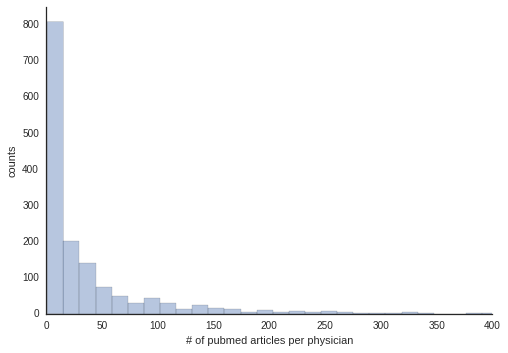

In [26]:
g = sns.distplot((summary.loc[~empty_list_mask,'article_cnt_per_npi_with_mi'].
                  map(lambda x: int(x)).
                  to_frame('article_cnt_per_npi_with_mi').
                  query('article_cnt_per_npi_with_mi > 0')), 
                 kde=False, bins=10000)
g.set(xlim=(0,400), ylim=(0, 850), xlabel='# of pubmed articles per physician', ylabel='counts')
sns.despine()

In [27]:
# write scraped data to file
summary[['npi','last_first_mi',
         'last_first','article_cnt_per_npi_with_mi',
         'uids_per_npi_with_mi']].to_csv("pubmed_article_cnt.csv")

In [28]:
if con: 
    con.close()